# Purpose: Experimentation with log normalization. I found that log normalization did not work very well as the model had difficulty attaining high accuracy.

In [1]:
import innvestigate
from keras.models import load_model
from keras.models import Model, Input
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize, AsymmetricPercentileInterval, LogStretch
from astropy.io import fits
from astropy import wcs
import skimage
import random
import scipy.stats as stats
import pickle as pkl
from functools import partial
from multiprocessing import Pool

Using TensorFlow backend.
/home/fwang/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fwang/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fwang/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fwang/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
# generated from generate_streak_distribution.py
params_gamma_width = [4.79235037, 11.40523025, 1.64361626]
params_gamma_amplitude = [1.09717868, 1.99999993, 3.7169828]
params_gamma_length = [4.16396709, 8.0180058, 2.68969172]

gain = 6.2

amp_factor = 1.5

std_size = 10

def gaussian(x, offset, std, amp):
    return amp * np.exp(-np.power(x - offset, 2.) / (2 * np.power(std, 2.)))


def gaussian_streak(width, offset, std, amp, bkg):
    dist = gaussian(np.arange(width), offset, std, amp) + bkg
    return dist

def implant_random_streak(image):

    image = np.copy(image)

    while True:
        std = stats.gamma.rvs(*params_gamma_width) * 0.05
        width = std * 10

        if random.random() < 0.7:
            length = stats.gamma.rvs(*params_gamma_length)
        else:
            length = np.random.random() * 30 + 10

        # use 2*std, which is "real" width
        if length / (std * 2) > 2 and length > 10 and width > 0:
            break

    streak = np.repeat(np.array([gaussian_streak(width, width / 2, std, 1, 0)]).T, length, axis=1)
    rotation = np.random.uniform(0, 360)
    streak = skimage.transform.rotate(streak, rotation, resize=True, order=3)

    y_len, x_len = image.shape
    y_len_streak, x_len_streak = streak.shape
    x_streak = np.random.randint(0, x_len - x_len_streak)
    y_streak = np.random.randint(0, y_len - y_len_streak)

    y1 = y_streak - std_size
    y2 = y_streak + y_len_streak + std_size
    y1 = max(0, y1)
    y2 = min(size, y2)
    
    x1 = x_streak - std_size
    x2 = x_streak + x_len_streak + std_size
    x1 = max(0, x1)
    x2 = min(size, x2)
    
    amp_min = np.std(image[y1:y2, x1:x2]) * amp_factor

    if random.random() < 0.9:
        amplitude = amp_min * (1 + abs(np.random.randn()))
    else:
        amplitude = (np.random.random() * 5) * amp_min

    streak *= amplitude

    # add shot noise
    streak = np.random.poisson(streak * gain)

    streak = streak / gain
    shape = streak.shape
    image[y_streak:y_streak + shape[0], x_streak:x_streak + shape[1]] += streak

    return image

In [3]:
size = 80
def normalize(arr, samples=size * size // 4):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)
    return (arr - 0.5) * 2

In [4]:
filenames = glob.glob("/media/rd1/ztf_neos/training_examples/aligned/*")

In [9]:
file = np.random.choice(filenames)
print(file)
sci, ref_ = np.load(file)

/media/rd1/ztf_neos/training_examples/aligned/ztf_20180716168206_000374_zg_c03_o_q1_sciimg.resamp.fits.npy


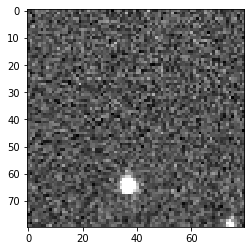

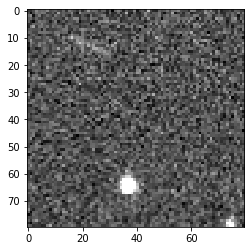

In [12]:
y = np.random.randint(0, 3000)
x = np.random.randint(0, 3000)
image = sci[y:y+80, x:x+80]
ref = ref_[y:y+80, x:x+80]
streak = implant_random_streak(image)

plt.imshow(normalize(image), cmap="gray")
plt.figure()
plt.imshow(normalize(streak), cmap="gray")

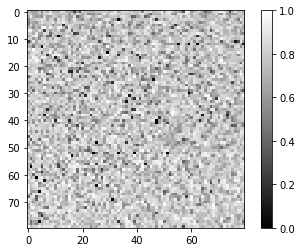

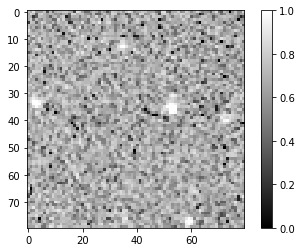

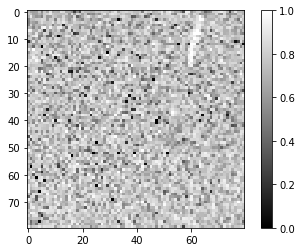

In [11]:
def add_dim(arr):
    return np.reshape(arr, (-1, 1, 1, 2))


# a = 1000
a = 0.1
def log_norm(images):
    lower = np.percentile(images, 0.25, axis=(1, 2))
    upper = np.percentile(images, 99.75, axis=(1, 2))
    ptp_percentile = upper - lower
#     images = (images - add_dim(np.amin(images, axis=(1, 2)))) / add_dim(np.ptp(images, axis=(1,2)))
    images = (images - add_dim(lower)) / add_dim(ptp_percentile)
    images = np.clip(images, 0, 1)
#     return np.log10(images - np.reshape(np.amin(images, axis=(1, 2)), (-1, 1, 1, 2)) + 1)
#     return np.log(a * images + 1) / np.log(a)
#     return (a ** images - 1) / a
    
    return np.arcsinh(images/a) / np.arcsinh(1/a)

image_norm, streak_norm = log_norm(np.array([np.transpose(np.array([image, ref]), [1, 2, 0]), np.transpose(np.array([streak, ref]), [1, 2, 0])]))

ref__ = image_norm[..., 1]

image_norm = image_norm[..., 0]
streak_norm = streak_norm[..., 0]

plt.imshow(image_norm, cmap="gray")
plt.colorbar()
plt.figure()
plt.imshow(ref__, cmap="gray")
plt.colorbar()
plt.figure()
plt.imshow(streak_norm, cmap="gray")
plt.colorbar()